In [1]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()

## Get the Raw data and create a copy

In [2]:
activities_data_raw = retrieve_activities()

Requesting new token...
Token received.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 54 activities.
-> Received page 4 with 0 activities.
...retrieved total of 454 activities.


In [3]:
# This can be re-run to refresh "data" in case of modification in case I don't want to request the raw_data again
activities_data = copy.deepcopy(activities_data_raw)
activities_df = pd.json_normalize(activities_data)

## Cleaning Data and converting to more useful formats/units

In [4]:
columns_of_interest = ["id", "name", "distance", "moving_time", "elapsed_time", "total_elevation_gain", "elev_high", "elev_low", 
                        "sport_type", "start_date_local", "timezone", "start_latlng", "end_latlng", "achievement_count", "map.id", 
                        "workout_type", "average_speed", "max_speed", "average_heartrate", "max_heartrate", "map.summary_polyline"]
activities_df = activities_df[columns_of_interest]
activities_df.head(1)

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,...,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline
0,9497056992,Afternoon Ride,53571.5,8180,8508,660.9,101.3,3.4,Ride,2023-07-21T17:07:28Z,...,"[49.05509015545249, -122.77446557767689]","[49.05509208329022, -122.77489724569023]",4,a9497056992,NaN,6.549,16.422,153.0,177.0,w`ljHjtjlVb@dBr@cAz@b@vBhPbDJAzq@RxPA|QW^pAxAk...


In [5]:
# Convert dates and times to datetime
activities_df["start_date_local"] = pd.to_datetime(activities_df["start_date_local"], format="%Y-%m-%dT%H:%M:%SZ")
for s in ["moving_time", "elapsed_time"]:
    activities_df[s] = pd.to_timedelta(activities_df[s], unit='S')
# Create a column holding only the year and a column 
activities_df["year"] = activities_df["start_date_local"].apply(lambda x: x.year)
activities_df["date_year_agnostic"] = activities_df["start_date_local"].apply(lambda x: x.replace(year=2020))

# Units
activities_df[["average_speed", "max_speed"]] = activities_df[["average_speed", "max_speed"]] * 3.6

# Filter
activities_df = activities_df.loc[activities_df.sport_type == "Ride"]     # Select only bicycling activities
activities_df = activities_df.loc[activities_df.max_speed > 0.1]          # Remove any throwaway activities
activities_df = activities_df.loc[activities_df.average_heartrate > 145]  # Remove any activities where I wasn't trying that hard
activities_df.head(2)

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,...,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,9497056992,Afternoon Ride,53571.5,0 days 02:16:20,0 days 02:21:48,660.9,101.3,3.4,Ride,2023-07-21 17:07:28,...,4,a9497056992,NaN,23.5764,59.1192,153.0,177.0,w`ljHjtjlVb@dBr@cAz@b@vBhPbDJAzq@RxPA|QW^pAxAk...,2023,2020-07-21 17:07:28
1,9491225277,Afternoon Ride,28455.6,0 days 01:07:23,0 days 01:09:18,353.2,101.3,3.4,Ride,2023-07-20 17:13:32,...,23,a9491225277,NaN,25.3368,60.1416,164.7,187.0,w`ljHfvjlVXt@v@a@~@d@@dAvA~HJbBZ`@TDbCQ@zKMlAJ...,2023,2020-07-20 17:13:32


In [57]:
df_test = activities_df.sort_values('start_date_local')[['start_date_local', 'distance', 'total_elevation_gain', 'year']].set_index('start_date_local').groupby('year').cumsum().reset_index()
df_test['year'] = pd.Categorical(df_test.start_date_local.apply(lambda x: x.year))
df_test['doy'] = df_test.start_date_local.apply(lambda x: x.timetuple().tm_yday)
df_melt = df_test.melt(id_vars=['start_date_local', 'year', 'doy'])
df_melt.head(30)

,start_date_local,year,doy,variable,value
0,2020-04-16 13:57:58,2020,107,distance,7278.0
1,2020-04-22 14:48:16,2020,113,distance,24883.8
2,2020-04-23 13:02:13,2020,114,distance,39400.8
3,2020-04-25 11:48:43,2020,116,distance,56917.6
4,2020-04-26 15:07:20,2020,117,distance,65882.2
5,2020-04-27 13:59:57,2020,118,distance,83393.2
6,2020-04-28 13:33:06,2020,119,distance,101222.5
7,2020-04-29 14:16:43,2020,120,distance,119027.7
8,2020-05-01 12:19:38,2020,122,distance,136871.7
9,2020-05-02 12:12:29,2020,123,distance,174687.1


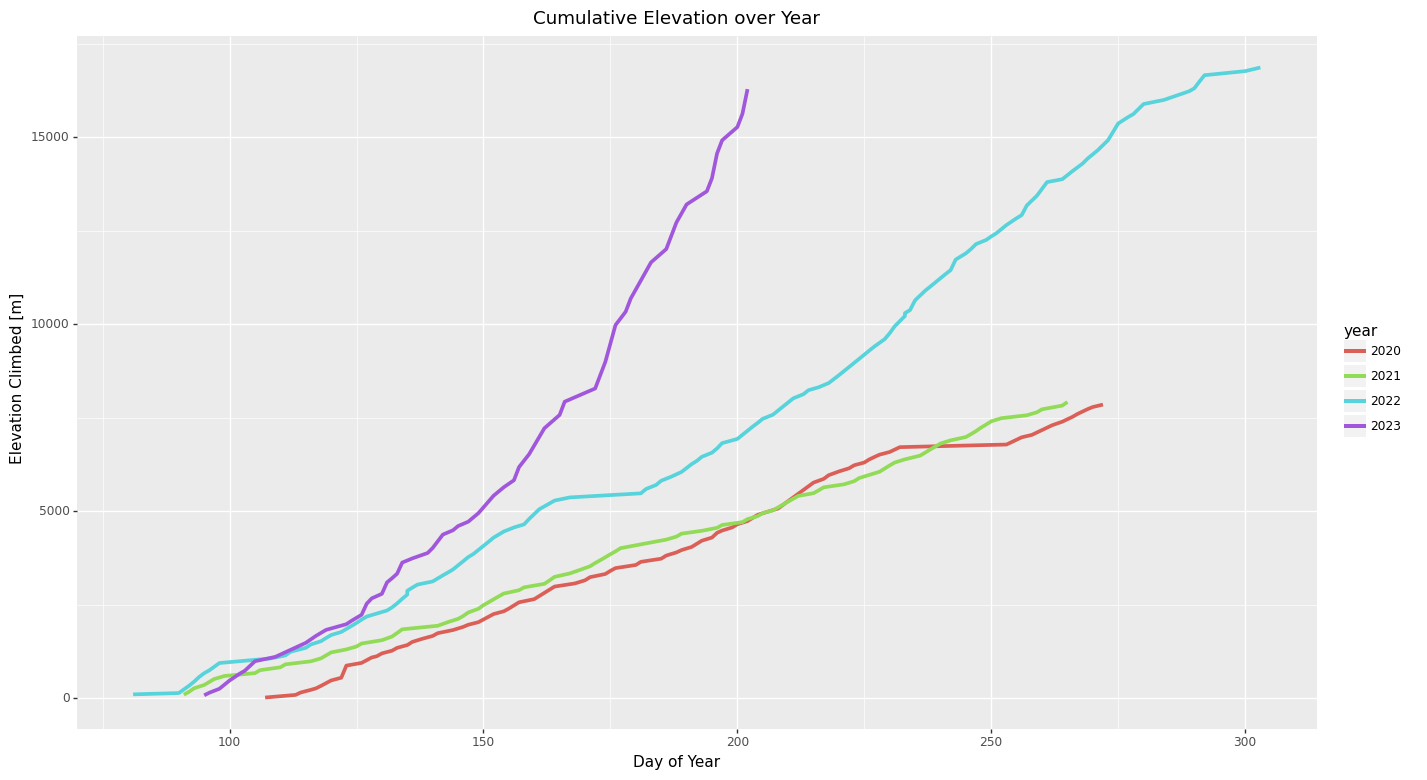

<ggplot: (378732731)>

In [91]:
(gg.ggplot(df_melt.query('variable == "total_elevation_gain"'), gg.aes(x='doy', y='value', colour='year')) 
    + gg.geom_line(size=1.5)
    + gg.theme(figure_size=(16, 9))
    + gg.labs(title='Cumulative Elevation over Year', x='Day of Year', y='Elevation Climbed [m]')
    )

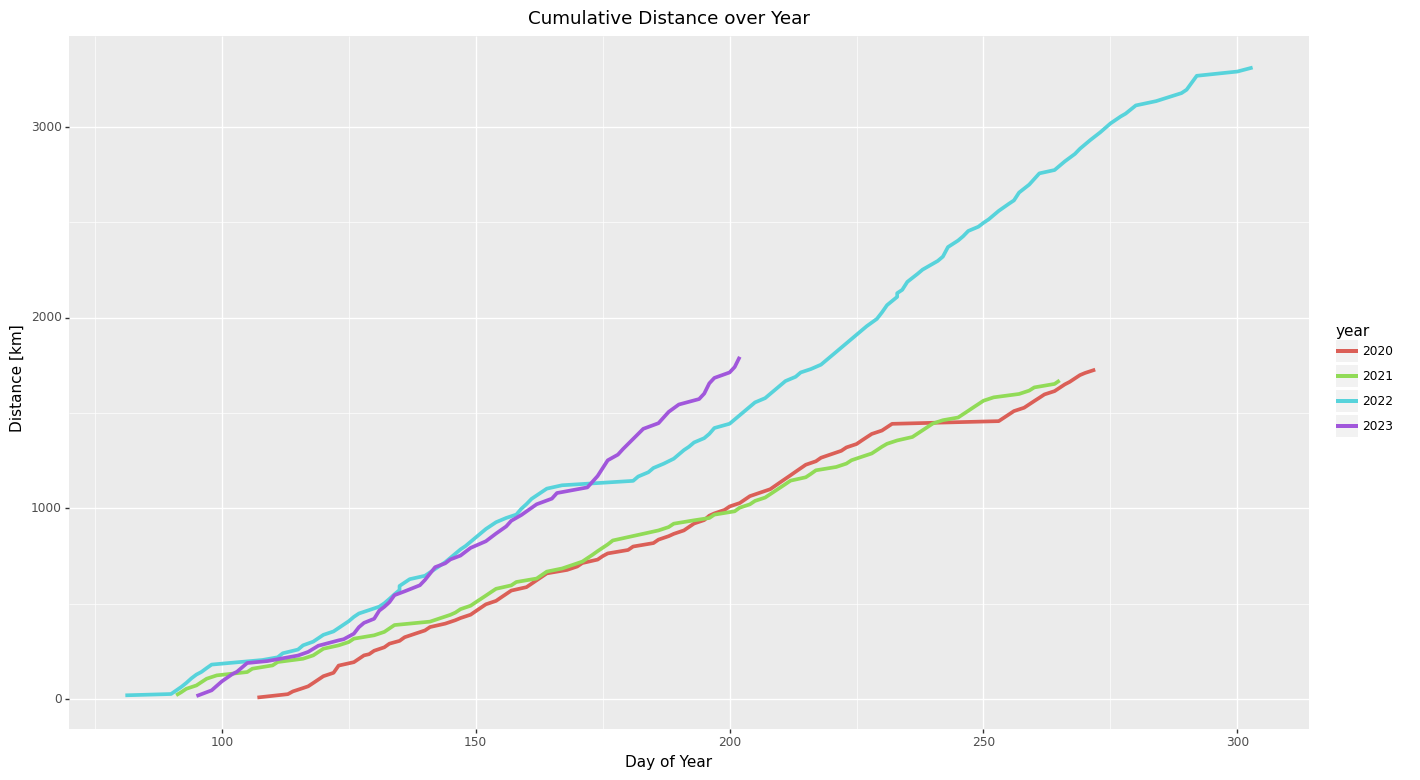

<ggplot: (378847920)>

In [89]:
(gg.ggplot(df_melt.query('variable == "distance"'), gg.aes(x='doy', y='value/1000', colour='year')) 
    + gg.geom_line(size=1.5)
    + gg.theme(figure_size=(16, 9))
    + gg.labs(title='Cumulative Distance over Year', x='Day of Year', y='Distance [km]')
    )

In [85]:
activities_df['e_v_d'] = activities_df.apply(lambda x: x.total_elevation_gain/x.distance * 100, axis=1)
activities_df['doy'] = activities_df.start_date_local.apply(lambda x: x.timetuple().tm_yday)

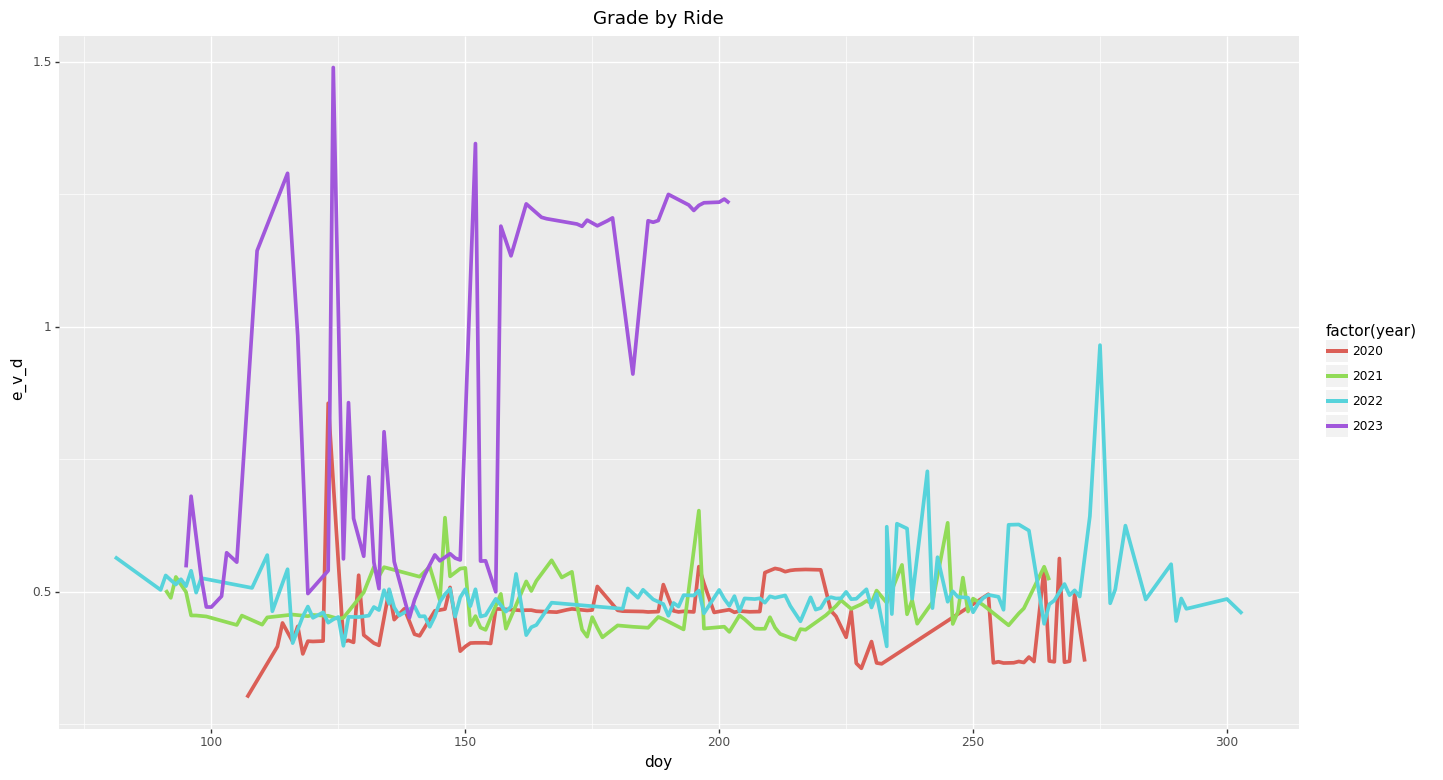

<ggplot: (378618169)>

In [86]:
(gg.ggplot(activities_df, gg.aes(x='doy', y='e_v_d', colour='factor(year)')) 
    + gg.geom_line(size=1.5)
    + gg.theme(figure_size=(16, 9))
    + gg.labs(title='Grade by Ride')
    )

## Getting a stream

In [12]:
cache = Cache()
ride_date = date(2022, 9, 18)
stream = create_stream_df(get_activity_stream_by_date(activities=activities_df, date=ride_date, cache=cache), activity_id_by_date(activities=activities_df, date=ride_date))
stream.rename({"velocity_smooth": "velocity"}, axis=1, inplace=True)
stream["velocity"] = stream["velocity"] * 3.6
stream.head(2)

Found activity 7830749817 in cache.


,moving,velocity,distance,altitude,heartrate,time,id
0,False,0.0,0.0,691.3,101,0,7830749817
1,True,0.0,4.0,691.4,101,1,7830749817


## Testing Plots

In [13]:
red = "#DD1616"
yellow = "#F0F01C"
green = "#17C903"
alt_heartcolor = ggplot(stream, aes(x="distance", y="altitude", color="heartrate")) \
    + gg.geom_line(size=1.5) \
    + gg.theme_light() + gg.theme(text=gg.element_text(color=stred)) \
    + gg.scale_colour_gradientn(colors=[green, yellow, red], values=[0, 0.7, 1])


## Create the Stream Plots

In [14]:
heartrate_plot = heartrate_with_altitude(stream=stream)
velocity_plot = velocity_with_altitude(stream=stream)
(heartrate_zone_plot, zone_plot) = heartrate_zones(stream=stream, heartrate_max=191)
summary = all_streams(stream, alpha=0.1)

## Save the plots, combine into single image

In [15]:
plot_height = 24
plot_width  = 48
transparent_background = False
heartrate_plot.save(filename="plots/heartrate_plot.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)
velocity_plot.save(filename="plots/velocity_plot.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)
heartrate_zone_plot.save(filename="plots/heartrate_zone_plot.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)
zone_plot.save(filename="plots/zone_plot.png", format="png", height=4, width=48, limitsize=False, transparent=transparent_background)
summary.save(filename="plots/stream_summary.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)

id = stream.iloc[0]["id"]
with open(f"plots/summary_{ride_date.isoformat()}_{id}.png", "wb") as fp:
    combine_plots_vertical(["plots/velocity_plot.png", "plots/heartrate_plot.png", "plots/heartrate_zone_plot.png", "plots/zone_plot.png"]).save(fp=fp, format="png")

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 48 x 24 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/heartrate_plot.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 48 x 24 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/velocity_plot.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 48 x 24 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/heartrate_zone_plot.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plo

## Annual Plots

In [16]:
subjects = ["heartrate", "speed", "distance", "elevation", "annual_time"]
plots = [annual_plot(activities=activities_df, subject=x) for x in subjects]

for i in range(len(subjects)):
    filename = f"plots/annual/{subjects[i]}.png"
    plots[i].save(filename=filename, format="png", height=9, width=16, transparent=transparent_background)

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 9 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/annual/heartrate.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_label : Removed 648 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 9 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/annual/speed.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_label : Removed 648 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/env

In [17]:
# profile = ProfileReport(activities_df, title="testing").to_notebook_iframe()

In [19]:
stream.describe()

,velocity,distance,altitude,heartrate,time,id
count,7530.000000,7530.000000,7530.000000,7530.000000,7530.000000,7.530000e+03
mean,27.775769,30286.419429,670.697357,164.817530,3912.153785,7.830750e+09
std,6.020742,17042.415379,14.582619,10.570292,2267.134771,0.000000e+00
min,0.000000,0.000000,650.100000,101.000000,0.000000,7.830750e+09
25%,24.848100,15477.025000,656.500000,159.000000,1971.250000,7.830750e+09
50%,28.364400,30560.250000,665.500000,166.000000,3890.500000,7.830750e+09
75%,31.290300,45072.400000,686.700000,172.000000,5865.750000,7.830750e+09
max,65.203200,58940.400000,696.000000,183.000000,7894.000000,7.830750e+09


/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 48 x 24 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/speed_histogram.png
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 100'. Pick better value with 'binwidth'.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 100'. Pick better value with 'binwidth'.


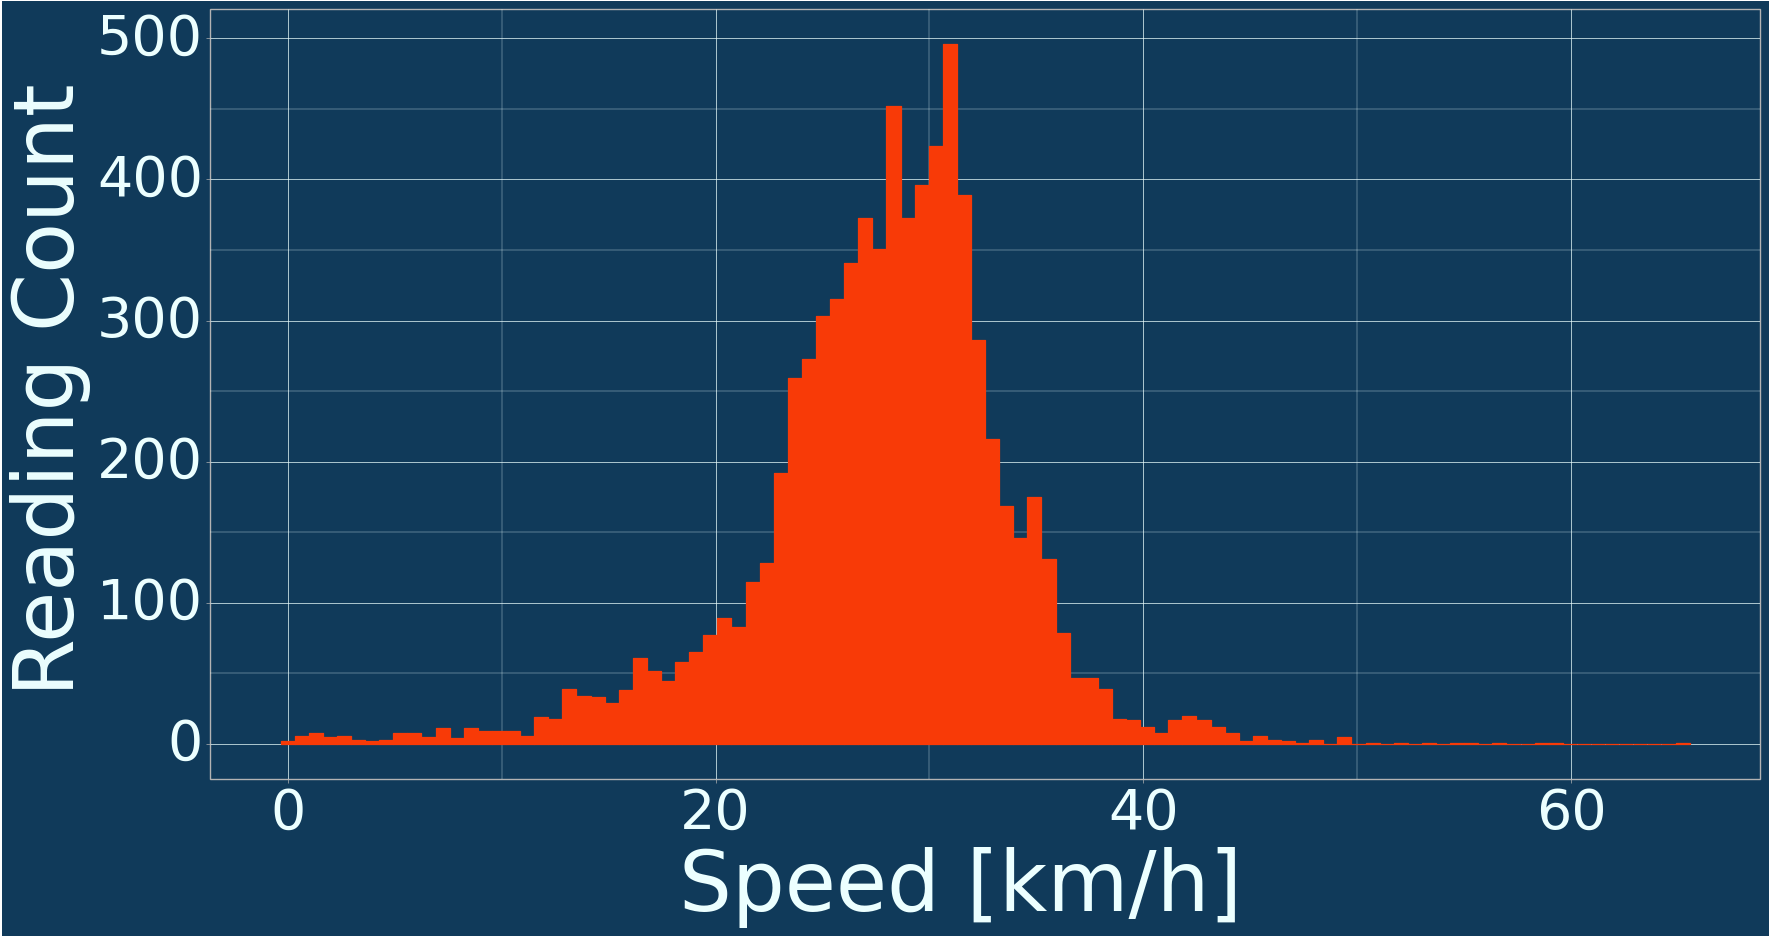

In [32]:
p = (ggplot(stream) + gg.geom_histogram(aes(x="velocity"), colour=stred, fill=stred) 
    + pt.gg_theme() 
    + gg.theme(figure_size=(20, 10))
    + gg.xlab("Speed [km/h]")
    + gg.ylab("Reading Count"))

p.save(filename="plots/speed_histogram.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=True)
print(p)